In [3]:
import warnings # Omitir mensajes de advertencia
warnings.filterwarnings("ignore")

In [ ]:
# Trabajamos en colab: 
from google.colab import drive 
drive.mount('/content/drive/')

import os

path = '/content/drive/MyDrive/Colab Notebooks/OCEANOGRAFIA/BOYA 0N170W/' # Directorio de trabajo

os.chdir(path)

In [ ]:
# #1|Install Conda environment on Colab
# !pip install -q condacolab
# import condacolab
# condacolab.install()
# #2|Install cartopy 
# !mamba install -q -c conda-forge cartopy

In [4]:
import pandas as pd
import xarray as xr 
import matplotlib.pyplot as plt
import numpy as np

In [5]:
import matplotlib.ticker as mticker
import cartopy.mpl.gridliner as gridliner
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import calendar
from matplotlib.colors import ListedColormap
from scipy.ndimage import gaussian_filter
from geopy.geocoders import Nominatim

In [6]:
sst = xr.open_dataset(path + 'sst.mon.mean.nc')
sst['time'] = pd.date_range('1981-09-01', '2023-06-01', freq = 'M')
sst

<xarray.Dataset>
Dimensions:  (time: 501, lat: 720, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 1981-09-30 1981-10-31 ... 2023-05-31
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    Conventions:    CF-1.5
    title:          NOAA/NCEI 1/4 Degree Daily Optimum Interpolation Sea Surf...
    institution:    NOAA/National Centers for Environmental Information
    source:         NOAA/NCEI https://www.ncei.noaa.gov/data/sea-surface-temp...
    References:     https://www.psl.noaa.gov/data/gridded/data.noaa.oisst.v2....
    dataset_title:  NOAA Daily Optimum Interpolation Sea Surface Temperature
    version:        Version 2.1
    comment:        Reynolds, et al.(2007) Daily High-Resolution-Blended Anal...

In [7]:
year_inicio = '1991'
year_fin = '2020'
# Calcular la clomatología 
clim = sst.sel(time=slice(f'{year_inicio}-01-01', f'{year_fin}-12-31')).groupby('time.month').mean(dim='time')
# Calcular la anomalía 
anom = sst.groupby('time.month') - clim
anom

<xarray.Dataset>
Dimensions:  (time: 501, lat: 720, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 1981-09-30 1981-10-31 ... 2023-05-31
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
    month    (time) int64 9 10 11 12 1 2 3 4 5 6 7 ... 7 8 9 10 11 12 1 2 3 4 5
Data variables:
    sst      (time, lat, lon) float32 nan nan nan ... -0.09194 -0.09194 -0.09194

In [13]:
def ANOM_ANIOS(data):
  fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
  # Seleccionar los datos de la anomalía
  anom_time = data
  anom_pacifico = anom_time.where((anom_time.lon >= 180) & (anom_time.lon <= 300) & (anom_time.lat >= -25) & (anom_time.lat <= 10), drop=True)
  lon, lat = np.meshgrid(anom_pacifico.lon, anom_pacifico.lat)
  # Crear los contornos
  contour_levels = np.arange(-8, 10, 1)
  cs = ax.contourf(lon, lat, anom_pacifico, levels=contour_levels, cmap='RdBu_r', extend='both', transform=ccrs.PlateCarree())
  # Agregar etiquetas de los ejes
  gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, color='gray', alpha=0, linestyle='--')
  gl.xlabels_top = False
  gl.ylabels_right = False
  # Añadir una barra de color
  cbar = fig.colorbar(cs, ax=ax, shrink=0.3, extend='both', ticks=np.arange(-8, 10, 2))
  # Añadir contornos
  cs = ax.contour(lon, lat, anom_pacifico, levels=contour_levels, colors='k', linewidths=0.5, transform=ccrs.PlateCarree())
  ax.clabel(cs, fmt='%1.0f', inline=True,inline_spacing=5, colors='black',fontsize= 8)
  #AGREGAMOS COSTAS (BORDE CONTINENTES), BORDES DE PAIS, GRILLADO 
  ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black', color='gainsboro') # CONTINENTES
  ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=1) # PAISES 
  ax.coastlines(resolution='110m', color='black', linewidth=1) #CONTINENTES

  ax.set_extent([185, 295, -25, 10], crs=ccrs.PlateCarree())
  ax.set_yticks([-25, -20, -15, -10, -5, 0, 5, 10])
  ax.set_yticklabels(['25°S', '20°S', '15°S', '10°S', '5°S', '0°', '5°N', '10°N'])
  ax.set_xticks([0,10,20,30,40,50,60,70,80,90,100,110])
  ax.set_xticklabels(['180°', '170°W','160°W', '150°W','140°W','130°W', '120°W', '110°W','100°W','90°W','80°W','70°W'])

  ax.plot([10, 60], [4.25, 4.25],
          [10, 60], [-4.25, -4.25],
          [10, 10], [-4.25, 4.25],
          [60, 60], [-4.25, 4.25],color='red',linestyle = '--',linewidth=0.8)

  ax.plot([90, 90], [-10, 0], [90, 100], [-10, -10],
          [100, 100], [-10, 0],
          [90, 100], [0, 0],color='red',linestyle = '-',linewidth=0.8)


  # NIÑO 3: 
  ax.plot([30, 90], [5, 5],
          [30, 90], [-5, -5],
          [30, 90], [-5, -5],
          [30, 30], [-5, 5],
          [30, 30], [-5, 5],
          [90, 90], [-5, 5],color='black',linewidth=0.8)  
  # ax.plot([90, 90], [-5, 5], color='black', linestyle = ':',linewidth=0.5)        

  ax.text(89, -13, 'NIÑO 1+2', fontsize=8)
  ax.text(30, -9, 'NIÑO 3.4', fontsize=8)
  ax.text(70, 6, 'NIÑO 3', fontsize=8)
 # #----------------------------------------------------------------------------------------- 
    # ESTILO :V 
  # Agregar el nombre del mes al título
  ax.set_title(f'ATSM Pacífico Central: {year} - {meses[month]}', fontsize=14, color='black')    

  ax.xaxis.label.set_color('black')
  ax.yaxis.label.set_color('black')
  ax.tick_params(colors='black')

  plt.text(0, -0.2, 'Fuente de datos: OISST V2', fontsize=12, ha='left', 
        va='center', color='black', transform=plt.gca().transAxes)
  #-----------------------------------------------------------------------------------------  
  fig.savefig(path + f'ATSM_Pcentral{year}-{month}.jpg', 
                  transparent = False, pad_inches = 0.1, dpi = 700, bbox_inches = 'tight')  
  plt.show()
  plt.close()


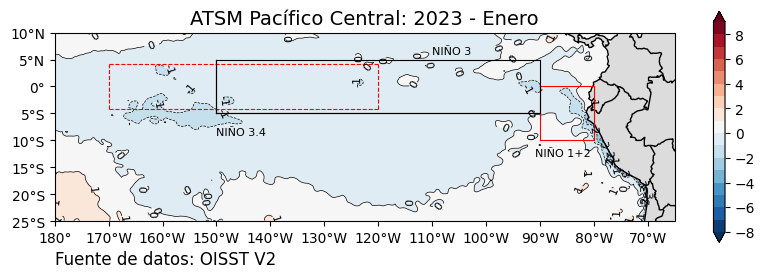

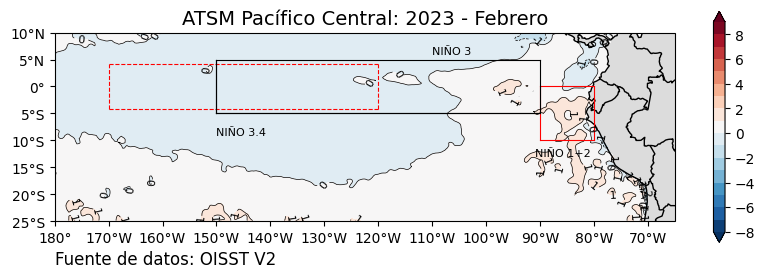

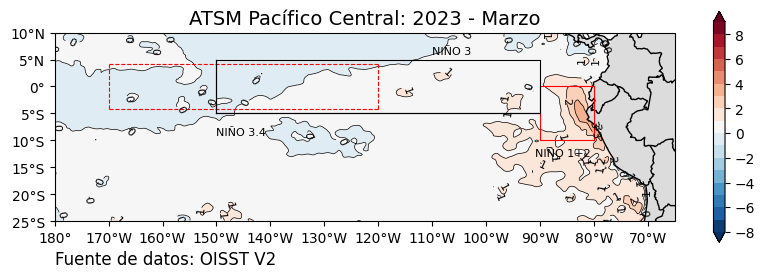

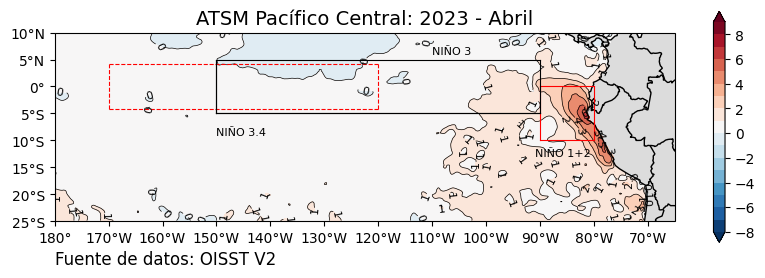

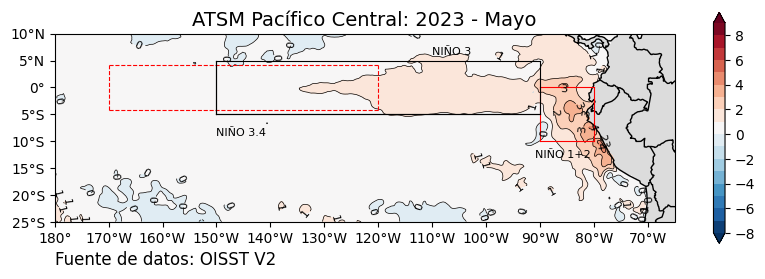

In [15]:
year = 2023
days = [31, 28, 31, 30,31,30,31,31,30,31,30,31]
months = [1, 2, 3, 4, 5]

for month in months:
    ANOM_ANIOS(anom.sst.sel(time=f'{year}-{month:02d}-{days[month-1]}'))


In [8]:
# Crear el diccionario de nombres de los meses
meses = {1: 'Enero', 2: 'Febrero', 3: 'Marzo', 4: 'Abril', 5: 'Mayo', 6: 'Junio', 
         7: 'Julio', 8: 'Agosto', 9: 'Septiembre', 10: 'Octubre', 11: 'Noviembre', 12: 'Diciembre'}

def ANOM_ANIOS(data, month,sigma):
  # Crear la figura y los ejes
  fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
  
  # Seleccionar los datos de la anomalía
  anom_time = data
  anom_pacifico = anom_time.where((anom_time.lon >= 260) & (anom_time.lon <= 290) & (anom_time.lat >= -25) & (anom_time.lat <= 10), drop=True)

  lon, lat = np.meshgrid(anom_pacifico.lon, anom_pacifico.lat)
  contour_levels = np.arange(-8, 10, 1)
  my_cmap = ListedColormap(plt.get_cmap('RdBu_r')(np.linspace(0, 1, 256))**1.5)
  # Suavizado de contornos y countor fill 
  sigma = sigma
  interp_temp_smooth = gaussian_filter(data, sigma=sigma)
  # Utilizar el mapa de colores personalizado en su gráfico
  cs = ax.contourf(lon, lat, anom_pacifico, interp_temp_smooth, cmap=my_cmap,levels=contour_levels, extend='both', transform=ccrs.PlateCarree())
  # Agregar etiquetas de los ejes
  gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, color='gray', alpha=0, linestyle='--')
  gl.xlabels_top = False
  gl.ylabels_right = False
  # Añadir una barra de color
  cbar = fig.colorbar(cs, ax=ax, shrink=1, extend='both', ticks=np.arange(-8, 10, 2))
  # Añadir contornos
  cs = ax.contour(lon, lat, anom_pacifico,interp_temp_smooth, levels=[-8, -7, -6, -5, -4, -3, -2, -1, 1, 2, 3, 4, 5, 6, 7, 8, 9], colors='dimgrey', linewidths=1, transform=ccrs.PlateCarree())
  ax.clabel(cs, fmt='%1.0f', inline=True,inline_spacing=5, colors='black',fontsize= 10)

  #AGREGAMOS COSTAS (BORDE CONTINENTES), BORDES DE PAIS, GRILLADO 
  ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black', color='gainsboro') # CONTINENTES
  ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=1) # PAISES 
  ax.coastlines(resolution='110m', color='black', linewidth=1) #CONTINENTES

  ax.set_extent([270, 290, -25, 10], crs=ccrs.PlateCarree())
  ax.set_yticks([-25, -20, -15, -10, -5, 0, 5, 10])
  ax.set_yticklabels(['25°S', '20°S', '15°S', '10°S', '5°S', '0°', '5°N', '10°N'])
  ax.set_xticks([90,95,100,105,110,115])
  ax.set_xticklabels(['90°W','85°W','80°W','75°W','70°W','65°W'])

  ax.plot([91, 91], [-10, 0], [91, 100], [-10, -10],
          [100, 100], [-10, 0],
          [91, 100], [0, 0],color='red',linestyle = '-')

  ax.text(92.5, -11.5, 'NIÑO 1+2', fontsize=10,fontweight='bold')
 # #----------------------------------------------------------------------------------------- 
  # Agregando la geolocalización de las ciudades: 
  ciudades = ['Paita Peru', 'Chimbote Perú','Callao Peru', 'Ilo Peru']
  geolocator = Nominatim(user_agent="my_app")

  coordenadas = []
  for ciudad in ciudades:
    location = geolocator.geocode(ciudad)
    coordenadas.append((location.latitude, location.longitude))

  for i, coord in enumerate(coordenadas):
      ax.plot(coord[1], coord[0], color='red', marker='o', markersize='5', markeredgecolor='black', transform=ccrs.PlateCarree())
      ax.text(coord[1]+0.35, coord[0]-0.3, ciudades[i].split(" ")[0], transform=ccrs.PlateCarree(), fontsize=8, color='black')
 # #----------------------------------------------------------------------------------------- 
    # ESTILO :V 
  # Agregar el nombre del mes al título
  ax.set_title(f'ATSM : {year} - {meses[month]}', fontsize=14, color='black')    

  ax.xaxis.label.set_color('black')
  ax.yaxis.label.set_color('black')
  ax.tick_params(colors='black')

  plt.text(0, -0.1, 'Fuente de datos: OISST V2', fontsize=12, ha='left', 
        va='center', color='black', transform=plt.gca().transAxes)
  #-----------------------------------------------------------------------------------------  
  fig.savefig(path + f'AnomTempSuP{year}-{month}.jpg', 
                  transparent = False, pad_inches = 0.1, dpi = 700, bbox_inches = 'tight')  
  # Mostrar la figura
  plt.show()
  plt.close()


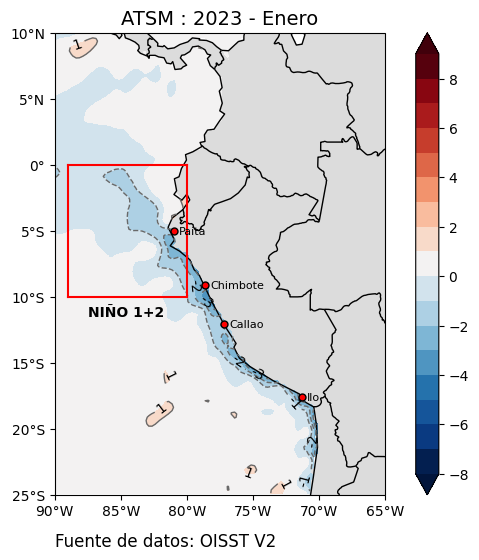

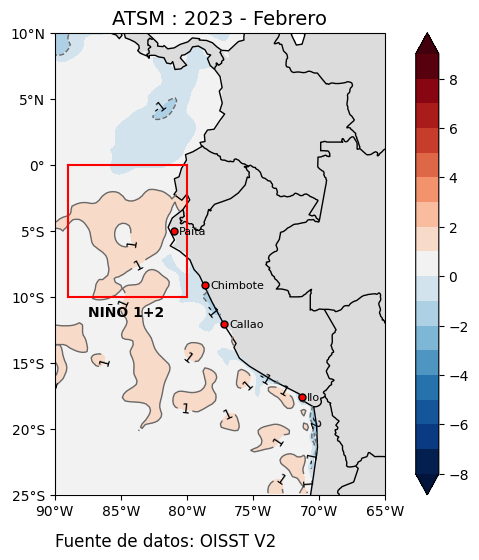

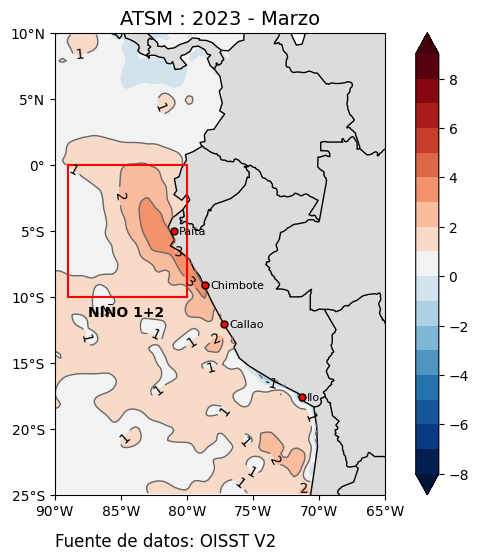

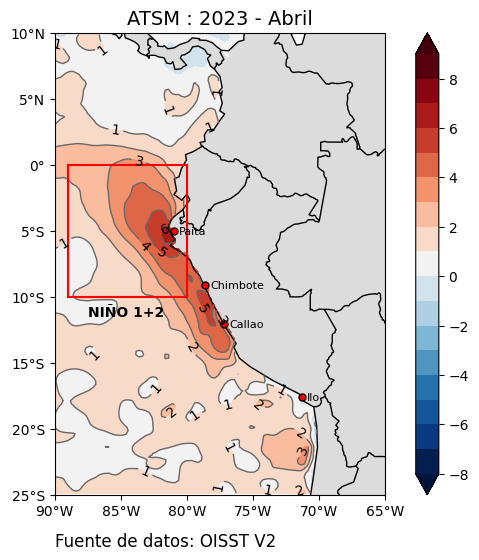

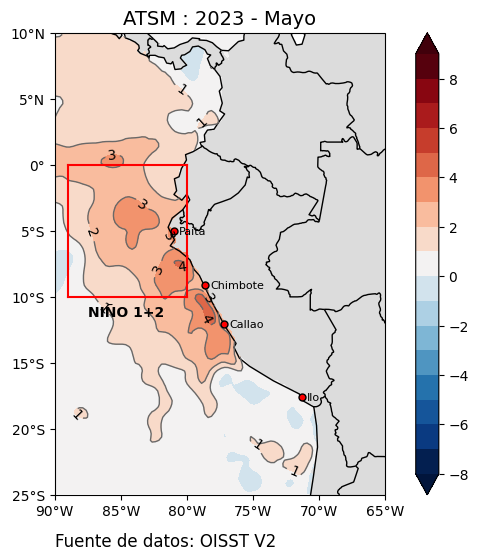

In [11]:
year = 2023
days = [31, 28, 31, 30, 31]
months = [1, 2, 3, 4, 5]
for month in months:
    ANOM_ANIOS(anom.sst.sel(time=f'{year}-{month:02d}-{days[month-1]}'), month,1.5)